# RFM ANALYSIS
You are provided a ‘’transactions’’ dataset that contains the following information: <br><br>


Each line corresponds to an item purchased<br><br>

Columns represent:<br><br>

trans_id = transaction/ invoice ID<br>
item_id = item ID<br>
cust_id = customer ID<br>
quantity = quantity purchased<br>
pur_date = date of purchase.<br><br>

You are also provided with a reference table “Product_Prices’’ that contains the price catalog for each item that appears in transactions. You shall use this information to calculate the Monetary value for each customer. (maybe join the tables could be helpful)<br><br>


You need to calculate the Recency, Frequency and Monetary Value for each customer.<br>
Create a meaningful labeling of your choice for different customer profiles.<br>

At the end of the day we will discuss:<br><br>


What actions would you suggest for customers with low Frequency and high Monetary Value?<br>

What actions would you suggest for customers with low Monetary Value and high Frequency ?<br>

What actions  would you suggest for customers with low Recency Score and high Frequency  and high Monetary Value?<br><br>

*For more information about RFM please check the readme file

In [33]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [5]:
# lets load our dataset with transactions
df=pd.read_csv('Datasets/transactions.csv')
df.head()

,trans_id,item_id,cust_id,quantity,pur_date
0,1,p_734,c_235717,16,12/17/2021
1,1,p_67,c_235717,10,8/22/2021
2,1,p_873,c_235717,8,2/11/2021
3,2,p_57,c_180583,15,2/9/2022
4,2,p_570,c_180583,20,12/22/2021


In [7]:
#explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934958 entries, 0 to 934957
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   trans_id  934958 non-null  int64 
 1   item_id   934958 non-null  object
 2   cust_id   934958 non-null  object
 3   quantity  934958 non-null  int64 
 4   pur_date  934958 non-null  object
dtypes: int64(2), object(3)
memory usage: 35.7+ MB


In [12]:
# Change column 'pur_date' to date datatype
df['pur_date'] = pd.to_datetime(df['pur_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934958 entries, 0 to 934957
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   trans_id  934958 non-null  int64         
 1   item_id   934958 non-null  object        
 2   cust_id   934958 non-null  object        
 3   quantity  934958 non-null  int64         
 4   pur_date  934958 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 35.7+ MB


In [9]:
# lets load our dataset with prices
df_prices=pd.read_csv('Datasets/Product_Prices.xlsx - Sheet1.csv')
df_prices.head()

,item_id,unit_price
0,p_1,6
1,p_2,13
2,p_3,31
3,p_4,37
4,p_5,40


In [10]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10024 entries, 0 to 10023
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     10024 non-null  object
 1   unit_price  10024 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.8+ KB


Now lets start building our dataset<br>
Transactions ''df'' left join ''prices_df'' will bring the unit_price for each item from the referance table to our main df

In [13]:
df=df.merge(df_prices, on='item_id', how='left')
df.head()

,trans_id,item_id,cust_id,quantity,pur_date,unit_price
0,1,p_734,c_235717,16,2021-12-17,20
1,1,p_67,c_235717,10,2021-08-22,42
2,1,p_873,c_235717,8,2021-02-11,2
3,2,p_57,c_180583,15,2022-02-09,35
4,2,p_570,c_180583,20,2021-12-22,38


For each item we have quantity purchased and unit price. In order to find total value of each receipt and later monetary for each customer we need to calculate the total cost of each line.

In [14]:
df['TotalSum'] = df['quantity'] * df['unit_price']
df.head()

,trans_id,item_id,cust_id,quantity,pur_date,unit_price,TotalSum
0,1,p_734,c_235717,16,2021-12-17,20,320
1,1,p_67,c_235717,10,2021-08-22,42,420
2,1,p_873,c_235717,8,2021-02-11,2,16
3,2,p_57,c_180583,15,2022-02-09,35,525
4,2,p_570,c_180583,20,2021-12-22,38,760


Dataset is current. Yet this is not always the case. For a dataset of 2010 for example, having more than 10 years passed if we calculate recency from today all customers will appear far away. Thus its better to create a snapshot date variable as the next day of last purchase and use this to count how much days have passed. (for this particular dataset we could also use today as referance date)

In [19]:
snapshot_date = df['pur_date'].max() + timedelta(days=1)
print(snapshot_date)

2022-05-02 00:00:00


Using group by for each customer we need we create three now columns as following <br>
 -Recency: for each customer snapshot date “ latest purchase difference in days<br>
 -Frequency: for each customer count of how many invoices are issued for him<br>
 -Monetary Value: for each customer sum of amount spent

In [20]:
data_process = df.groupby(['cust_id']).agg({
        'pur_date': lambda x: (snapshot_date - x.max()).days,
        'trans_id': 'count',
        'TotalSum': 'sum'})

In [21]:
data_process.rename(columns={'pur_date': 'Recency',
                         'trans_id': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

data_process.head()

,Recency,Frequency,MonetaryValue
cust_id,,,
c_100,121,4,360
c_10000,364,1,100
c_100001,276,1,792
c_100002,386,1,195
c_100003,30,2,380


We have now calculated our values. But those aggregations are absolut and hard to explain as is. It is better to normalize our scores replacing those values with relative once with respect to the distribution <br><br>
Pandas qcut splits numeric columns into quartiles.<br><br>
For Recency and Frequency columns, the higher values (top quartile) are assigned with indicator 4 and lowest to 1. Higher values imply that customers have spent more money to our products or bought more often and the 1-4 score is assigned accordingly<br><br>
The opposite logic is applied for recency as higher values mean that many days have passed since last purchase. Thus, customers with high values (top quartile) take score 1 and those with the smallest values 4.

In [22]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new columns R,F and M 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values,M = m_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F,M
cust_id,,,,,,
c_100,121,4,360,2,3,1
c_10000,364,1,100,1,1,1
c_100001,276,1,792,1,1,3
c_100002,386,1,195,1,1,1
c_100003,30,2,380,4,1,2


In [23]:
rfm = data_process.copy()
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M
cust_id,,,,,,
c_100,121,4,360,2,3,1
c_10000,364,1,100,1,1,1
c_100001,276,1,792,1,1,3
c_100002,386,1,195,1,1,1
c_100003,30,2,380,4,1,2


In [24]:
# Calculate total RFM score for each customer
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm['RFM_Score'].head()

cust_id
c_100       6
c_10000     3
c_100001    5
c_100002    3
c_100003    7
Name: RFM_Score, dtype: int64

In [25]:
# plit customers to segments and give indicative names (labeling appoaches may vary for this step)
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Average'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
cust_id,,,,,,,,
c_100,121,4,360,2,3,1,6,Potential
c_10000,364,1,100,1,1,1,3,Require Activation
c_100001,276,1,792,1,1,3,5,Average
c_100002,386,1,195,1,1,1,3,Require Activation
c_100003,30,2,380,4,1,2,7,Loyal


In [26]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
rfm_level_agg

Recency Frequency MonetaryValue       
                      mean      mean          mean  count
RFM_Level                                                
Average              173.7       1.9         502.3  31285
Can't Loose Them      59.8       5.7        1681.9  97634
Champions             93.5       3.4         956.3  24903
Loyal                106.1       2.8         783.9  27564
Needs Attention      243.6       1.5         368.9  31818
Potential            121.5       2.3         591.3  31390
Require Activation   335.5       1.2         166.1  29250

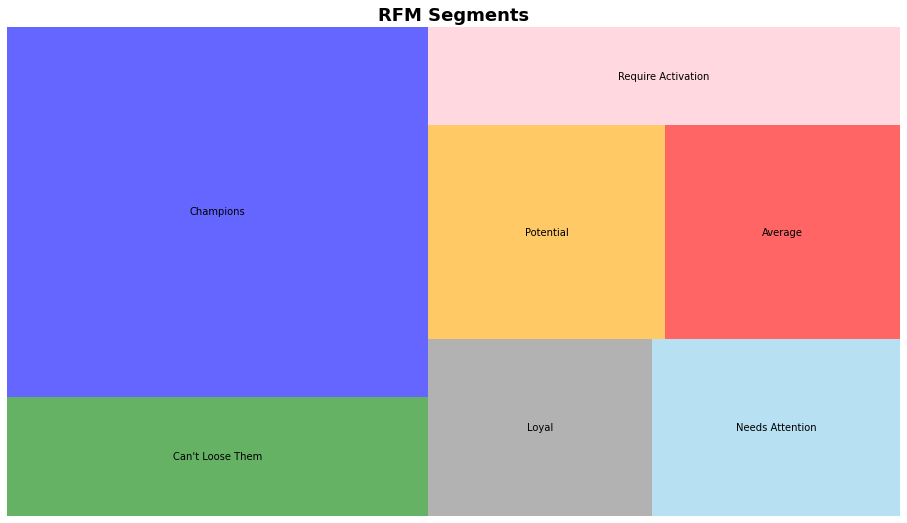

In [37]:
#Visualize the results
import squarify
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Average', 
                     'Require Activation'],
              color=["green","blue", "grey",'skyblue','orange',"red",'pink'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()